In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [9]:
class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs
        
        layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = [np.random.randn(layers[i], layers[i+1])*0.1 for i in range(len(layers)-1)]
        self.biases = [np.zeros(layers[i+1]) for i in range(len(layers)-1)]
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_propagate(self, x):
        self.activations = [x]  # store activations
        activation = x
        for w, b in zip(self.weights, self.biases):
            net_input = np.dot(activation, w) + b
            activation = self._sigmoid(net_input)
            self.activations.append(activation)
        return activation
    
    def back_propagate(self, y_true):
        # compute delta for output
        delta = self.activations[-1] - y_true
        self.deltas = [delta]
        
        # backward through hidden layers
        for i in reversed(range(len(self.weights)-1)):
            delta = np.dot(self.deltas[0], self.weights[i+1].T) * self._sigmoid_derivative(self.activations[i+1])
            self.deltas.insert(0, delta)
    
    def update_weights(self, lr):
        for i in range(len(self.weights)):
            a = np.atleast_2d(self.activations[i])
            d = np.atleast_2d(self.deltas[i])
            self.weights[i] -= lr * np.dot(a.T, d)
            self.biases[i] -= lr * d.flatten()
    
    def train(self, X, Y, epochs=1000, lr=0.01, verbose=False):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                out = self.forward_propagate(x)
                self.back_propagate(y)
                self.update_weights(lr)
                total_loss += np.mean((out - y)**2)
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, MSE: {total_loss/len(X):.6f}")
    
    def predict(self, x):
        return self.forward_propagate(x)


In [12]:
# Functions to learn
def func_simple(x):
    return x

def func_medium(x):
    return np.sin(x)

def func_complex(x):
    return x * np.sin(x) + 0.5 * x**2

# Generate data
def generate_data(func, num_samples=100, x_range=(0,10), noise=0.0):
    X = np.linspace(x_range[0], x_range[1], num_samples).reshape(-1,1)
    Y = func(X)
    if noise > 0.0:
        Y += np.random.normal(0, noise, size=Y.shape)
    return X, Y

# Train and plot
def train_and_plot(func, name, noise=0.0, hidden_layers=[10,10], epochs=2000, lr=0.01):
    X, Y = generate_data(func, num_samples=100, x_range=(0,10), noise=noise)
    mlp = MLP(num_inputs=1, hidden_layers=hidden_layers, num_outputs=1)
    
    # Train
    mlp.train(X, Y, epochs=epochs, lr=lr, verbose=False)
    
    # Test
    X_test = np.linspace(0, 10, 500).reshape(-1,1)
    Y_true = func(X_test)
    Y_pred = np.array([mlp.predict(x)[0] for x in X_test])
    
    mse = np.mean((Y_true - Y_pred)**2)
    print(f"{name} function, MSE: {mse:.6f}")
    
    plt.figure(figsize=(8,4))
    plt.plot(X_test, Y_true, label='True function')
    plt.plot(X_test, Y_pred, label='MLP Prediction')
    plt.scatter(X, Y, color='red', s=10, label='Training points')
    plt.title(f"{name} function (noise={noise})")
    plt.legend()
    plt.show()


In [21]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load digits dataset
digits = load_digits()
X = digits.data / 16.0 
y = digits.target
num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
Y_train = np.eye(num_classes)[y_train]
Y_test = np.eye(num_classes)[y_test]

mlp_digits = MLP(num_inputs=X.shape[1], hidden_layers=[32, 32], num_outputs=num_classes)
mlp_digits.train(X_train, Y_train, epochs=500, lr=0.01, verbose=True)

Y_pred = np.array([mlp_digits.predict(x) for x in X_test])
y_pred_classes = np.argmax(Y_pred, axis=1)

accuracy = np.mean(y_pred_classes == y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")


Epoch 0, MSE: 0.093194
Epoch 100, MSE: 0.001930
Epoch 200, MSE: 0.000267
Epoch 300, MSE: 0.000049
Epoch 400, MSE: 0.000017
Test accuracy: 96.39%


Epoch 0, MSE: 0.076446
Epoch 100, MSE: 0.014637
Epoch 200, MSE: 0.011508
Epoch 300, MSE: 0.009914
Epoch 400, MSE: 0.008963


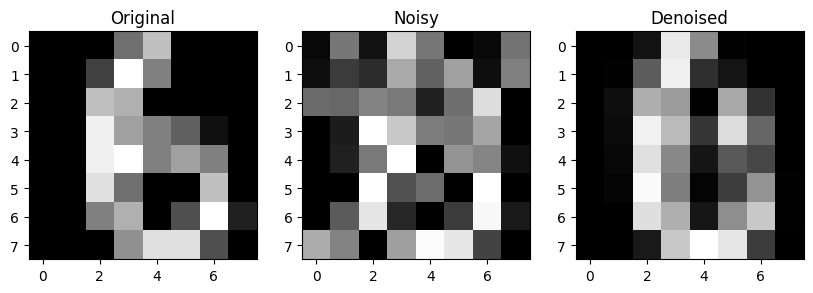

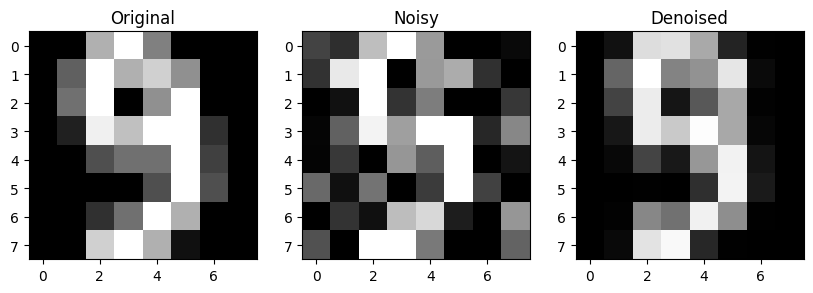

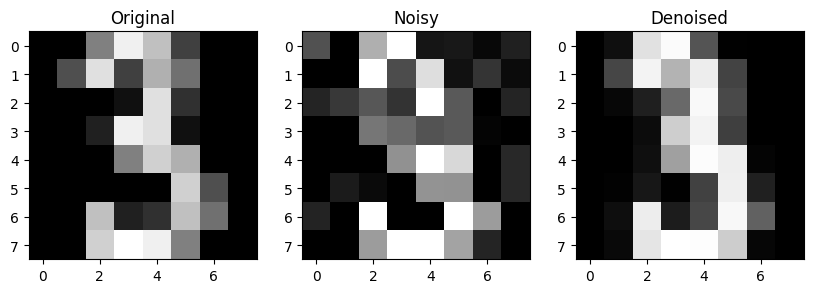

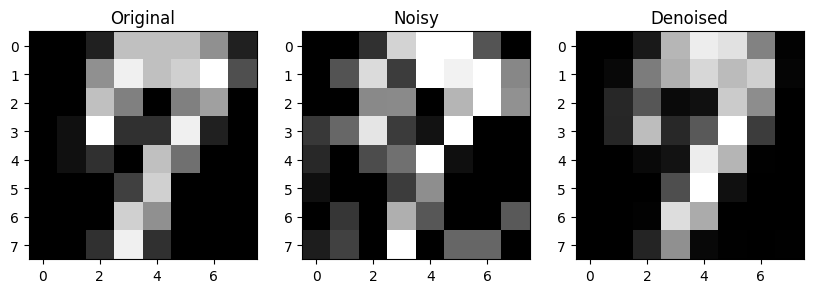

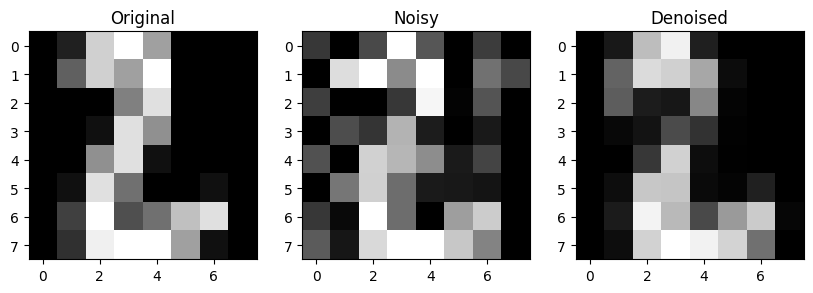

In [22]:
# Add noise to training and test images
noise_level = 0.3
X_train_noisy = X_train + noise_level * np.random.randn(*X_train.shape)
X_test_noisy = X_test + noise_level * np.random.randn(*X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0, 1)
X_test_noisy = np.clip(X_test_noisy, 0, 1)

mlp_denoise = MLP(num_inputs=X.shape[1], hidden_layers=[64, 64], num_outputs=X.shape[1])
mlp_denoise.train(X_train_noisy, X_train, epochs=500, lr=0.01, verbose=True)

# Test denoising
X_test_denoised = np.array([mlp_denoise.predict(x) for x in X_test_noisy])

# Show original, noisy, and denoised for first 5 samples
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(10,3))
    
    plt.subplot(1,3,1)
    plt.imshow(X_test[i].reshape(8,8), cmap='gray')
    plt.title("Original")
    
    plt.subplot(1,3,2)
    plt.imshow(X_test_noisy[i].reshape(8,8), cmap='gray')
    plt.title("Noisy")
    
    plt.subplot(1,3,3)
    plt.imshow(X_test_denoised[i].reshape(8,8), cmap='gray')
    plt.title("Denoised")
    
    plt.show()
